In [2]:
pip install torch torchvision transformers scikit-learn pandas numpy matplotlib

target
1    50051
0    49949
Name: count, dtype: int64
         target                                               text
551218        0                             I don't want to leave 
1512535       1  good nite all! sleep tight don't let the bed b...
1295295       1  It's a beautiful day! Guess who's going to see...
893979        1                    yay for ikea swedish meatballs 
279338        0  and God knows how many more SingStar and Buzz ...


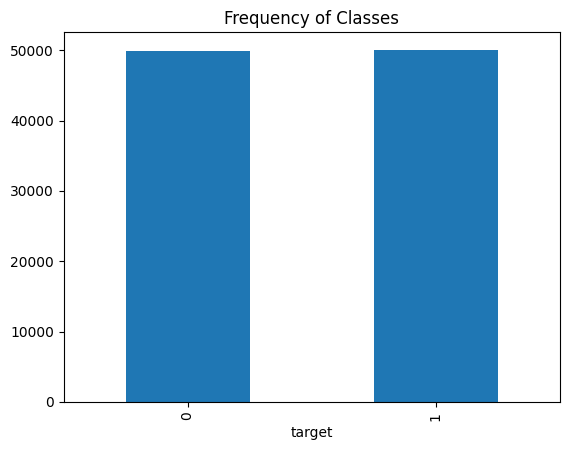

In [3]:
import pandas as pd
import numpy as np

# Load Sentiment social media data dataset
columns = ["target", "ids", "date", "flag", "user", "text"]
df_data = pd.read_csv("/content/social_media_data.csv", encoding="latin-1", names=columns)
# Randomly sample 100,000 rows
df = df_data.sample(n=100000, random_state=40)  # Set random_state for reproducibility

# Retain only the required columns
df = df[["target", "text"]]

# Map target labels: 0 -> Negative, 4 -> Positive
df["target"] = df["target"].map({0: 0, 4: 1})

# Check dataset distribution
print(df["target"].value_counts())
print(df.head())
import matplotlib.pyplot as plt
label_counts = df['target'].value_counts(ascending=True)
label_counts.plot.bar()
plt.title('Frequency of Classes')
plt.show()

In [4]:
import re
#from transformers import RobertaTokenizer, RobertaModel
from transformers import DebertaV2ForSequenceClassification
from transformers import DebertaV2Tokenizer
import torch

# Load Deberta tokenizer

tokenizer = DebertaV2Tokenizer.from_pretrained('microsoft/deberta-v3-base')

# Clean text function
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#\w+", "", text)  # Remove hashtags
    text = re.sub(r"[^A-Za-z\s]", "", text)  # Remove special characters
    return text.lower().strip()

# Apply cleaning
df["text"] = df["text"].apply(clean_text)

# Tokenize and encode text using Deberta tokenizer
def tokenize_data(texts, labels, max_len=128):
    encodings = tokenizer(
        list(texts),
        truncation=True,
        padding=True,
        max_length=max_len,
        return_tensors="pt",
    )
    labels = torch.tensor(labels.values)
    return encodings, labels

# Split data into training and testing sets
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"], df["target"], test_size=0.25, random_state=42
)

train_encodings, train_labels = tokenize_data(train_texts, train_labels)
test_encodings, test_labels = tokenize_data(test_texts, test_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
import torch
from transformers import DebertaV2ForSequenceClassification
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained DeBerta model
model = DebertaV2ForSequenceClassification.from_pretrained("microsoft/deberta-v3-small")
model = model.to(device)  # Move the model to the appropriate device

Using device: cuda


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from tqdm import tqdm
import torch
from torch.cuda.amp import GradScaler, autocast
from torch.utils.checkpoint import checkpoint

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Helper function to reduce batch size dynamically
def reduce_batch_size(loader, batch_size):
    new_batch_size = max(batch_size // 2, 1)
    print(f"Reducing batch size to {new_batch_size}")
    loader = DataLoader(loader.dataset, batch_size=new_batch_size, shuffle=True, pin_memory=True)
    return loader, new_batch_size

# Create DataLoaders
batch_size = 16  # Initial batch size
train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)

# Move model to appropriate device
model = model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Gradient scaler for mixed precision
scaler = GradScaler()
accumulation_steps = 4  # Accumulate gradients over this many steps

# Training loop with memory management
epochs = 5
while True:  # Retry mechanism for dynamic batch size reduction
    try:
        for epoch in range(epochs):
            model.train()
            total_loss = 0
            loop = tqdm(train_loader, leave=True)

            optimizer.zero_grad()

            for i, batch in enumerate(loop):
                batch = {key: val.to(device) for key, val in batch.items()}

                # Forward pass with mixed precision
                with autocast():
                    outputs = model(**batch)
                    loss = outputs.loss / accumulation_steps  # Normalize loss for accumulation

                # Backward pass
                scaler.scale(loss).backward()

                if (i + 1) % accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()

                total_loss += loss.item() * accumulation_steps  # Scale back for display

                # Update progress bar
                loop.set_description(f"Epoch {epoch + 1}")
                loop.set_postfix(loss=loss.item() * accumulation_steps)

            torch.cuda.empty_cache()  # Clear GPU memory after each epoch
            print(f"Epoch {epoch + 1} Loss: {total_loss / len(train_loader)}")

        break  # Exit loop if training completes successfully

    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            torch.cuda.empty_cache()  # Clear memory before retrying
            train_loader, batch_size = reduce_batch_size(train_loader, batch_size)
        else:
            raise e


<ipython-input-6-e89829e197f6>:48: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Using device: cuda


  0%|          | 0/4688 [00:00<?, ?it/s]<ipython-input-6-e89829e197f6>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1: 100%|██████████| 4688/4688 [05:43<00:00, 13.64it/s, loss=0.693]


Epoch 1 Loss: 0.3989479900210613


Epoch 2: 100%|██████████| 4688/4688 [05:40<00:00, 13.77it/s, loss=0.168]


Epoch 2 Loss: 0.31245088267438875


Epoch 3: 100%|██████████| 4688/4688 [05:39<00:00, 13.81it/s, loss=0.163]


Epoch 3 Loss: 0.23089378892401163


Epoch 4: 100%|██████████| 4688/4688 [05:47<00:00, 13.48it/s, loss=0.0335]


Epoch 4 Loss: 0.16064008735771904


Epoch 5: 100%|██████████| 4688/4688 [05:40<00:00, 13.77it/s, loss=0.0296]


Epoch 5 Loss: 0.1056895590280728


Using device: cuda
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     12449
           1       0.83      0.83      0.83     12551

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



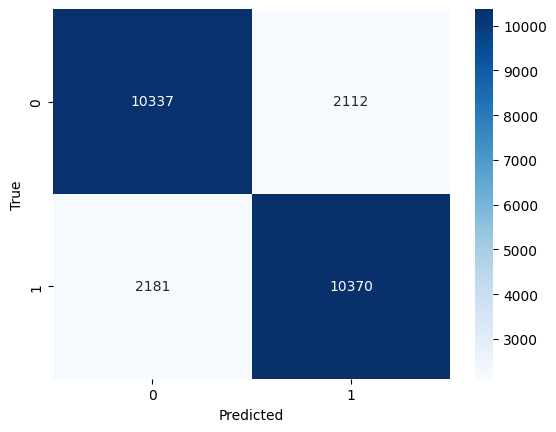

In [9]:
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Evaluation loop
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        # Move batch data to the appropriate device
        batch = {key: val.to(device) for key, val in batch.items()}

        # Forward pass
        outputs = model(**batch)

        # Predictions and labels
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()  # Move predictions to CPU for metrics
        labels = batch["labels"].cpu().numpy()  # Move labels to CPU

        all_preds.extend(preds)
        all_labels.extend(labels)

# Generate the classification report
print(classification_report(all_labels, all_preds))
# confusion metrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [10]:
model.save_pretrained("sentiment_model")
tokenizer.save_pretrained("sentiment_model")

('sentiment_model/tokenizer_config.json',
 'sentiment_model/special_tokens_map.json',
 'sentiment_model/spm.model',
 'sentiment_model/added_tokens.json')